In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

In [64]:
import numpy as np
import pandas as pd
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


In [29]:
df = pd.read_csv("/content/embeddinged.csv")
df.head()

,Unnamed: 0,id,name,popularity,artist,lyrics,embedding
0,0,0WbMK4wrZ1wFSty9F7FCgu,"Good Luck, Babe!",92,Chappell Roan,"[Verse 1]\nIt's fine, it's cool\nYou can say t...",[-6.57925056e-03 7.37103494e-03 2.48466711e-...
1,1,3HMY0r2BAdpasXMY8rseR0,Too Sweet,78,Hozier,[Verse 1]\nIt can't be said I'm an early bird\...,[-5.88894216e-03 3.87746887e-03 1.18451123e-...
2,2,3tLVfEh8kJhMkDaxvOzK1M,Insecure,47,Tom Misch,"[Verse 1]\nI heard this guy, says he wants you...",[-6.44976739e-03 5.58970962e-03 2.41238624e-...
3,3,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,96,Billie Eilish,[Intro]\n(But I wanna stay)\n\n[Verse 1]\nI wa...,[-7.92034529e-03 5.41314110e-03 -4.40973556e-...
4,4,5eVG50IlyjSevPsWnSI76r,The Thrill Is Gone.,58,RAYE,"[Verse 1]\nCard games and heart games\nI said,...",[-5.20136720e-03 5.12599619e-03 -4.59201518e-...


In [30]:
df['embedding'] = df['embedding'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))


X = df['embedding'].values
X = np.stack(X, axis=0)
y = df['popularity']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
pca_train = PCA(n_components=0.95)

X_train_pca = pca_train.fit_transform(X_train)
X_test_pca = pca_train.transform(X_test)

In [5]:
X_train_pca.shape

(66, 49)

In [6]:
X_test_pca.shape

(17, 49)

In [8]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("xgb", xgb.XGBRegressor(objective='reg:squarederror'))
])

param_dist = {
    "xgb__learning_rate": uniform(0.01, 0.3),
    "xgb__max_depth": randint(3, 6),
    "xgb__n_estimators": randint(50, 200),
    "xgb__subsample": uniform(0.6, 0.4),
    "xgb__reg_alpha": uniform(0, 1),
    "xgb__reg_lambda": uniform(0, 1),
}

search = RandomizedSearchCV(
    pipeline,
    param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)

In [9]:
search.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA(n_components=0.95)),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None...
                                        'xgb__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a810c7604d0>,
                                        'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a810c38fa90>,
                                        'xgb__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a810c3740d0>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a810cda0d10>},
                   random_state=42, scoring='neg_mean_squared_error')

In [10]:
best_model = search.best_estimator_
print("Best RMSE:", np.sqrt(-search.best_score_))
print("Best Params:", search.best_params_)

Best RMSE: 15.85855885359315
Best Params: {'xgb__learning_rate': 0.19349594814648427, 'xgb__max_depth': 3, 'xgb__n_estimators': 138, 'xgb__reg_alpha': 0.2912291401980419, 'xgb__reg_lambda': 0.6118528947223795, 'xgb__subsample': 0.6557975442608167}


In [11]:
best_params = {k.replace("xgb__", ""): v for k, v in search.best_params_.items()}
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

In [12]:
importances = best_model.named_steps["xgb"].feature_importances_
print(importances)

[1.0880544e-02 2.7608493e-02 1.9588000e-03 5.0268373e-03 4.3472290e-04
 1.1244988e-02 1.0547255e-03 1.6271383e-02 1.2777232e-02 1.9603927e-02
 2.1229221e-03 6.6447211e-03 8.8581070e-03 1.5436022e-02 2.2452449e-02
 2.5748271e-02 8.5237466e-02 3.2889766e-05 5.1022298e-04 5.3319759e-03
 1.0328595e-01 3.4820229e-02 3.9428840e-03 3.8859252e-02 2.9146036e-03
 1.4257120e-02 1.4694228e-02 6.0276765e-02 1.1693338e-03 4.6373885e-03
 4.4633225e-02 8.0138557e-03 3.9094232e-02 4.4340403e-03 1.3183465e-02
 5.3352804e-04 8.3376214e-02 5.7680476e-02 2.0704595e-02 2.9562477e-03
 1.2237596e-02 6.4443775e-02 7.7058841e-03 1.6947167e-02 7.3880157e-03
 1.4338262e-05 5.8558807e-02]


In [13]:
y_pred = best_model.predict(X_test_pca)
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

R2 Score: 0.05068999528884888


In [14]:
best_xgb_model.fit(X_train_pca, y_train)

y_pred_test = best_xgb_model.predict(X_test_pca)


r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(np.mean((y_test - y_pred_test)**2))

print(f"Test R2 Score: {r2_test}")
print(f"Test RMSE: {rmse_test}")


Test R2 Score: -0.2751591205596924
Test RMSE: 11.868393506294813


In [15]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)


        return x


In [32]:
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


input_size = X_train_pca.shape[1]
model = MLP(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [33]:
num_epochs = 100
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    test_loss = 0.0
    for batch_X, batch_y in test_loader:
      outputs = model(batch_X)
      loss = criterion(outputs,batch_y)
      test_loss += loss.item()
    average_test_loss = test_loss / len(test_loader)
    print("Average test loss: ", average_test_loss)

Epoch [1/100], Loss: 8507.3535
Epoch [2/100], Loss: 5120.2300
Epoch [3/100], Loss: 5133.8975
Epoch [4/100], Loss: 5719.8394
Epoch [5/100], Loss: 4383.1431
Epoch [6/100], Loss: 2945.8127
Epoch [7/100], Loss: 5969.1748
Epoch [8/100], Loss: 5013.1245
Epoch [9/100], Loss: 5362.1514
Epoch [10/100], Loss: 5470.4238
Epoch [11/100], Loss: 7910.1792
Epoch [12/100], Loss: 4783.8047
Epoch [13/100], Loss: 3615.7712
Epoch [14/100], Loss: 5884.8750
Epoch [15/100], Loss: 5100.1577
Epoch [16/100], Loss: 2664.9209
Epoch [17/100], Loss: 3604.7700
Epoch [18/100], Loss: 6838.3301
Epoch [19/100], Loss: 6553.1328
Epoch [20/100], Loss: 6666.6074
Epoch [21/100], Loss: 2920.1084
Epoch [22/100], Loss: 5255.7437
Epoch [23/100], Loss: 6956.2373
Epoch [24/100], Loss: 3738.8887
Epoch [25/100], Loss: 5171.0942
Epoch [26/100], Loss: 7902.6904
Epoch [27/100], Loss: 3492.4321
Epoch [28/100], Loss: 3779.5684
Epoch [29/100], Loss: 973.5211
Epoch [30/100], Loss: 5588.2681
Epoch [31/100], Loss: 4497.8389
Epoch [32/100], Lo

In [38]:
y_test.values

array([58, 92, 80, 57, 72, 56, 73, 66, 58, 61, 68, 78, 54, 64, 49, 66, 64])

In [45]:
y_pred_mlp = model(X_test_tensor).detach().numpy()

In [47]:
y_pred_mlp = y_pred_mlp.reshape(-1)

In [48]:
y_pred

array([73.22631 , 84.44604 , 72.618416, 59.769966, 65.10667 , 67.441216,
       68.7645  , 64.58761 , 71.00465 , 65.11431 , 76.06807 , 77.883064,
       76.06586 , 62.856174, 64.2756  , 72.97057 , 78.55941 ],
      dtype=float32)

In [49]:
print("R2 Score: ", r2_score(y_test, y_pred_mlp))
print("RMSE: ", np.sqrt(np.mean((y_test - y_pred_mlp)**2)))


R2 Score:  -0.25500595569610596
RMSE:  11.77423297912092


In [50]:
lr_model = LinearRegression()
lr_model.fit(X_train_pca, y_train)

y_pred = lr_model.predict(X_test_pca)

r2_lr = r2_score(y_test, y_pred)
rmse_lr = np.sqrt(np.mean((y_test- y_pred)**2))

print(f"Linear Regression Test R2 Score: {r2_lr}")
print(f"Linear Regression Test RMSE: {rmse_lr}")

Linear Regression Test R2 Score: -0.06208585609027084
Linear Regression Test RMSE: 10.831523401791157


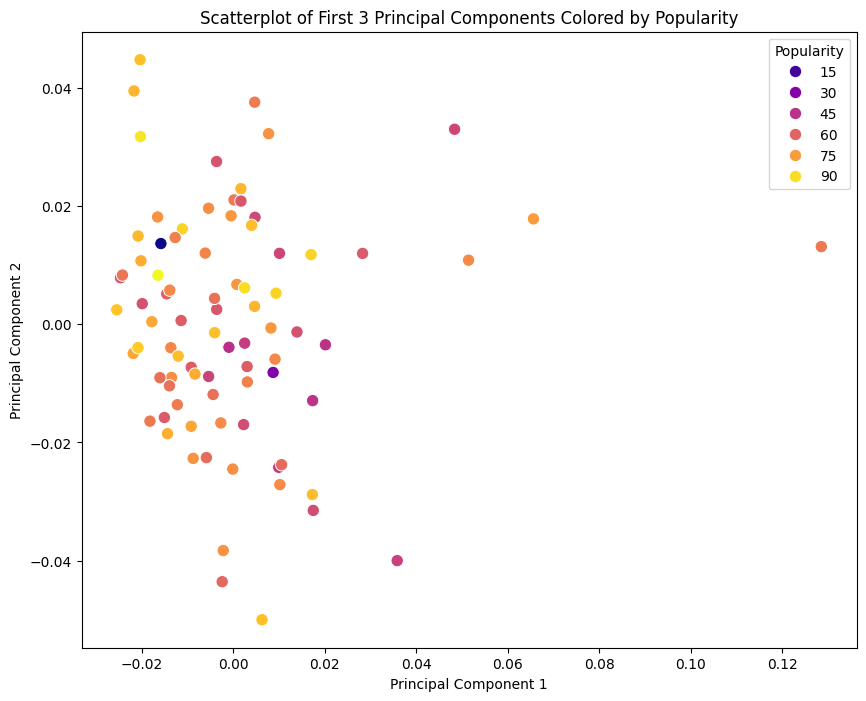

In [65]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['popularity'] = y

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='popularity', data=pca_df, palette='plasma', s=80)
plt.title('Scatterplot of First 3 Principal Components Colored by Popularity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Popularity')
plt.show()


In [66]:
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='popularity',
                    color_continuous_scale='plasma', opacity=0.7)
fig.show()
